<a href="https://colab.research.google.com/github/afrojaakter/Surrogate-Based-Optimization/blob/main/Bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Problem statement
We would like to Solve $$X^* = arg \min_x f(x)$$

under the constraints:
- $f$ is a black box i.e. no we don't know f explicitely
- $f$ is expensive to compute
- $y = f(x)$ may be noisy


# Bayesian Optimization loop
for $t = 1: T$

1. Given observations $(x_i, f(x_i))$ for $i = 1:t$, build a probabilistic model for the objective $f$. Integrate out all possible true functions, using Gaussian process regression.

2. Optimize a cheap acquisition/utility function $u$ based on the posterior distribution for sampling the next point. $x_{t + 1} = arg \min_x u(x)$ Exploit uncertainty to balance exploration against exploitation.
3. Sample the next observation $f(x_{t + 1})$ at $x_{t + 1} $



###Acquisition functions
Acquisition functions $u(x)$ specify which sample $x$ should be tried next:

- Expected improvement (default): $-EI(x) = - E[f(x) = f(x^*)]$
- Lower confidence bound: 

Probability of improvement: 

where 
 is the best point observed so far.

In most cases, acquisition functions provide knobs (e.g., ) for controlling the exploration-exploitation trade-off. - Search in regions where 
 is high (exploitation) - Probe regions where uncertainty 
 is high (exploration)

In [10]:
!pip install scikit-optimize

ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt


In [11]:
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

Automatically created module for IPython interactive environment


###Toy example
Let assume the following noisy function $f$:

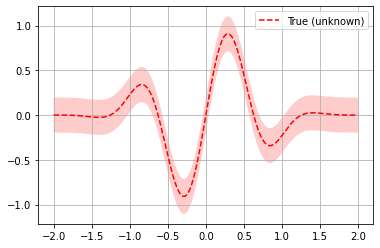

In [13]:
noise_level = 0.1
def f(x, noise_level = noise_level):
  return np.sin(5*x[0]) * (1 - np.tanh(x[0]**2)) + np.random.randn()*noise_level

# Plot f(x) + coutours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level = 0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

In [14]:
#Bayesian optimization based on gaussian process regression 
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

In [15]:
print(res)

          fun: -1.0146594077693436
    func_vals: array([ 0.03716044,  0.00673852,  0.63515442, -0.16042062,  0.10695907,
       -0.23193728, -0.60259431, -0.04943778, -1.01465941, -0.98480886,
       -0.87449015,  0.18102445, -0.10782771,  0.01197229, -0.80618926])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=822569775), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=822569775), Gau

$f = -1.0146594077693436, x = -0.35076964213550554$

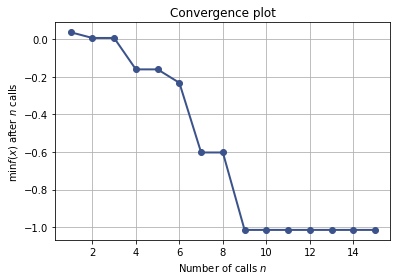

In [16]:
from skopt.plots import plot_convergence
plot_convergence(res);

In [17]:
plt.rcParams["figure.figsize"] = (8, 14)


def f_wo_noise(x):
    return f(x, noise_level=0)

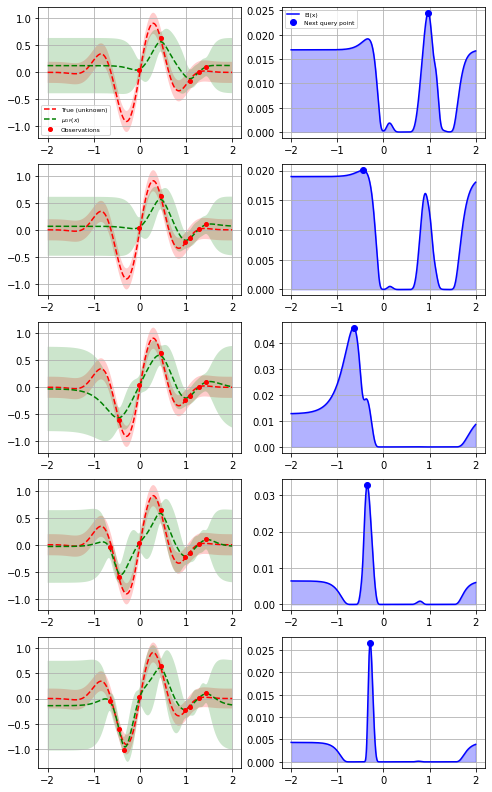

In [18]:
for n_iter in range(5):
    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res, n_calls=n_iter,
                               objective=f_wo_noise,
                               noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, n_calls=n_iter,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

The first column shows the following:

- The true function.

- The approximation to the original function by the gaussian process model

- How sure the GP is about the function.

The second column shows the acquisition function values after every surrogate model is fit. It is possible that we do not choose the global minimum but a local minimum depending on the minimizer used to minimize the acquisition function.

At the points closer to the points previously evaluated at, the variance dips to zero.

Finally, as we increase the number of points, the GP model approaches the actual function. The final few points are clustered around the minimum because the GP does not gain anything more by further exploration:

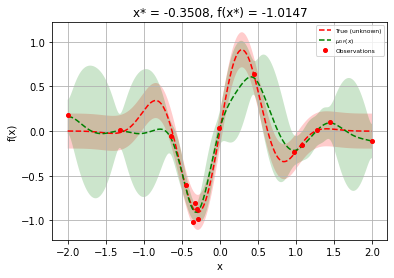

In [19]:
plt.rcParams["figure.figsize"] = (6, 4)

# Plot f(x) + contours
_ = plot_gaussian_process(res, objective=f_wo_noise,
                          noise_level=noise_level)

plt.show()

Reference: https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html